# Handling High Dimensional Data
When dealing with high-dimensional data, it is common to reduce the data set by generating a smaller set of variables that attempt to encapsulate as much of the information as possible from the original variables. There are several potential benefits to removing variables prior to modeling:

- A reduced number of variables translates into reduced computational time and complexity. 
- The presence of highly correlated variables indicates that they measure the same underlying information. In such cases, removing one of the correlated variables should not affect the model's performance and could result in a more interpretable model. 
- The removal of redundant predictors makes the model leaner and, most importantly, less prone to overfitting.
- Redundant variables often add more complexity to the model than the information they provide.

Here, we tackle a solubility dataset with a high number of correlated columns by using different approaches, among which:
- Heuristic reduction
- Principal Component Regression (PCR)
- Partial Least Squares (PLS)
- Penalized Regression: Lasso and Ridge regression

In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit
from sklearn.pipeline import make_pipeline

**Note**: We will use the solubility dataset, which has already been curated and transformed for skewness and centering/scaling. https://search.r-project.org/CRAN/refmans/AppliedPredictiveModeling/html/solubility.html

In [47]:
df = pd.read_csv("solubility.csv")

In [48]:
X = df[df.columns.difference(["Solubility"])]
y = df["Solubility"]

In [49]:
X.shape # there are 228 covariates

(951, 228)

In [50]:
X.head()

,FP001,FP002,FP003,FP004,FP005,FP006,FP007,FP008,FP009,FP010,...,NumMultBonds,NumNitrogen,NumNonHAtoms,NumNonHBonds,NumOxygen,NumRings,NumRotBonds,NumSulfer,SurfaceArea1,SurfaceArea2
0,0,1,0,0,1,0,0,1,0,0,...,5.264609,0.584815,2.833213,4.009916,0.000000,1.386294,0.000000,0.000,6.812456,6.812456
1,0,1,0,1,1,1,1,1,0,0,...,4.684412,0.642355,3.295837,4.871752,0.693147,1.609438,1.609438,0.375,9.753834,12.029604
2,1,1,1,1,1,0,0,1,0,1,...,3.243492,0.000000,2.772589,3.705506,1.098612,0.693147,1.609438,0.000,8.245324,8.245324
3,0,0,1,0,0,0,1,0,0,0,...,1.379614,0.000000,2.397895,3.076971,0.000000,0.693147,0.693147,0.000,0.000000,0.000000
4,0,0,1,1,1,1,0,0,1,0,...,2.944766,0.694335,2.772589,3.705506,0.000000,0.693147,1.791759,0.000,9.913535,9.913535


#### Perform the train test split

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=30)

### Initial Analysis: Ordinary Least Squares (OLS) Regression with All Variables

We will fit a simple OLS regression model to serve as a benchmark for comparison in the subsequent parts of the notebook.

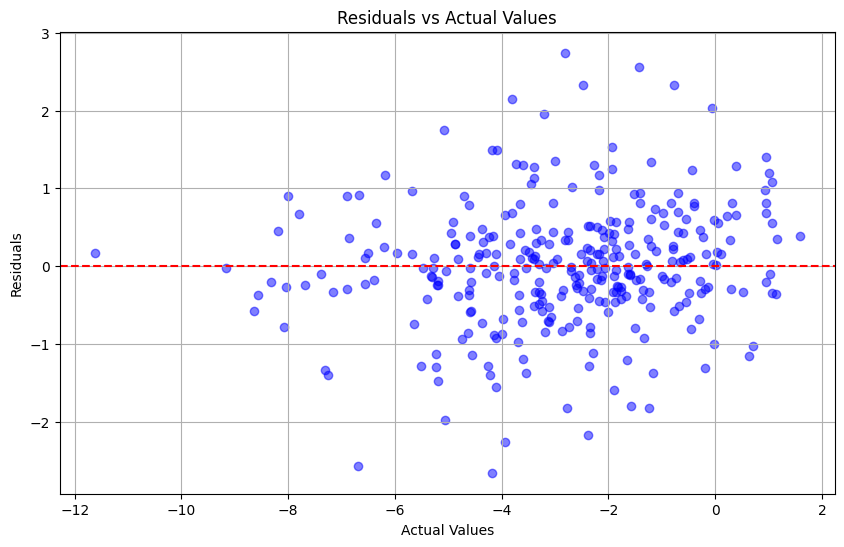

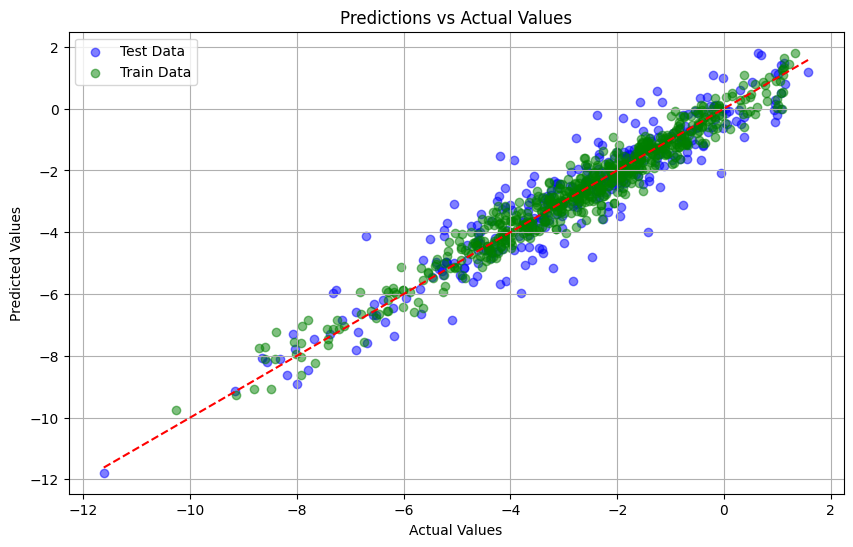

In [52]:
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
y_fitted = reg.predict(X_train)

residuals=y_test-y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, color='blue', alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5, label='Test Data')
plt.scatter(y_train, y_fitted, color='green', alpha=0.5, label='Train Data')
plt.plot(np.linspace(min(y), max(y)), np.linspace(min(y), max(y)), color='red', linestyle='--')
plt.title('Predictions vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

The residuals are scattered around zero. One may think there can be a problem for smaller y-values but I think by taking a look to the dataset that the population of smaller y-values is undersampled.

### Cross-validation

We use cross validation (k=5) to have a more precise understanding of the performance of the model.

In [53]:
reg = LinearRegression()

cv = ShuffleSplit(n_splits=5, test_size=0.33, random_state=30)

scores = cross_val_score(reg, X,y, cv=cv, scoring="neg_root_mean_squared_error")
# Why neg root mean squared error?
# https://stackoverflow.com/questions/62514395/score-obtained-from-cross-val-score-is-rmse-or-mse
# https://stackoverflow.com/questions/48244219/is-sklearn-metrics-mean-squared-error-the-larger-the-better-negated

cv_rmse = np.mean(-1*scores)

print(f"Cross-validated RMSE: {cv_rmse}")

Cross-validated RMSE: 0.7792700899693864


### Heuristic Dimensionality Reduction
In this heuristic approach, we aim to reduce the dimensionality of the dataset by iteratively removing variables with high (in absolute value) pairwise correlations above a certain threshold. We aim to mitigate multicollinearity and enhance the model's interpretability.

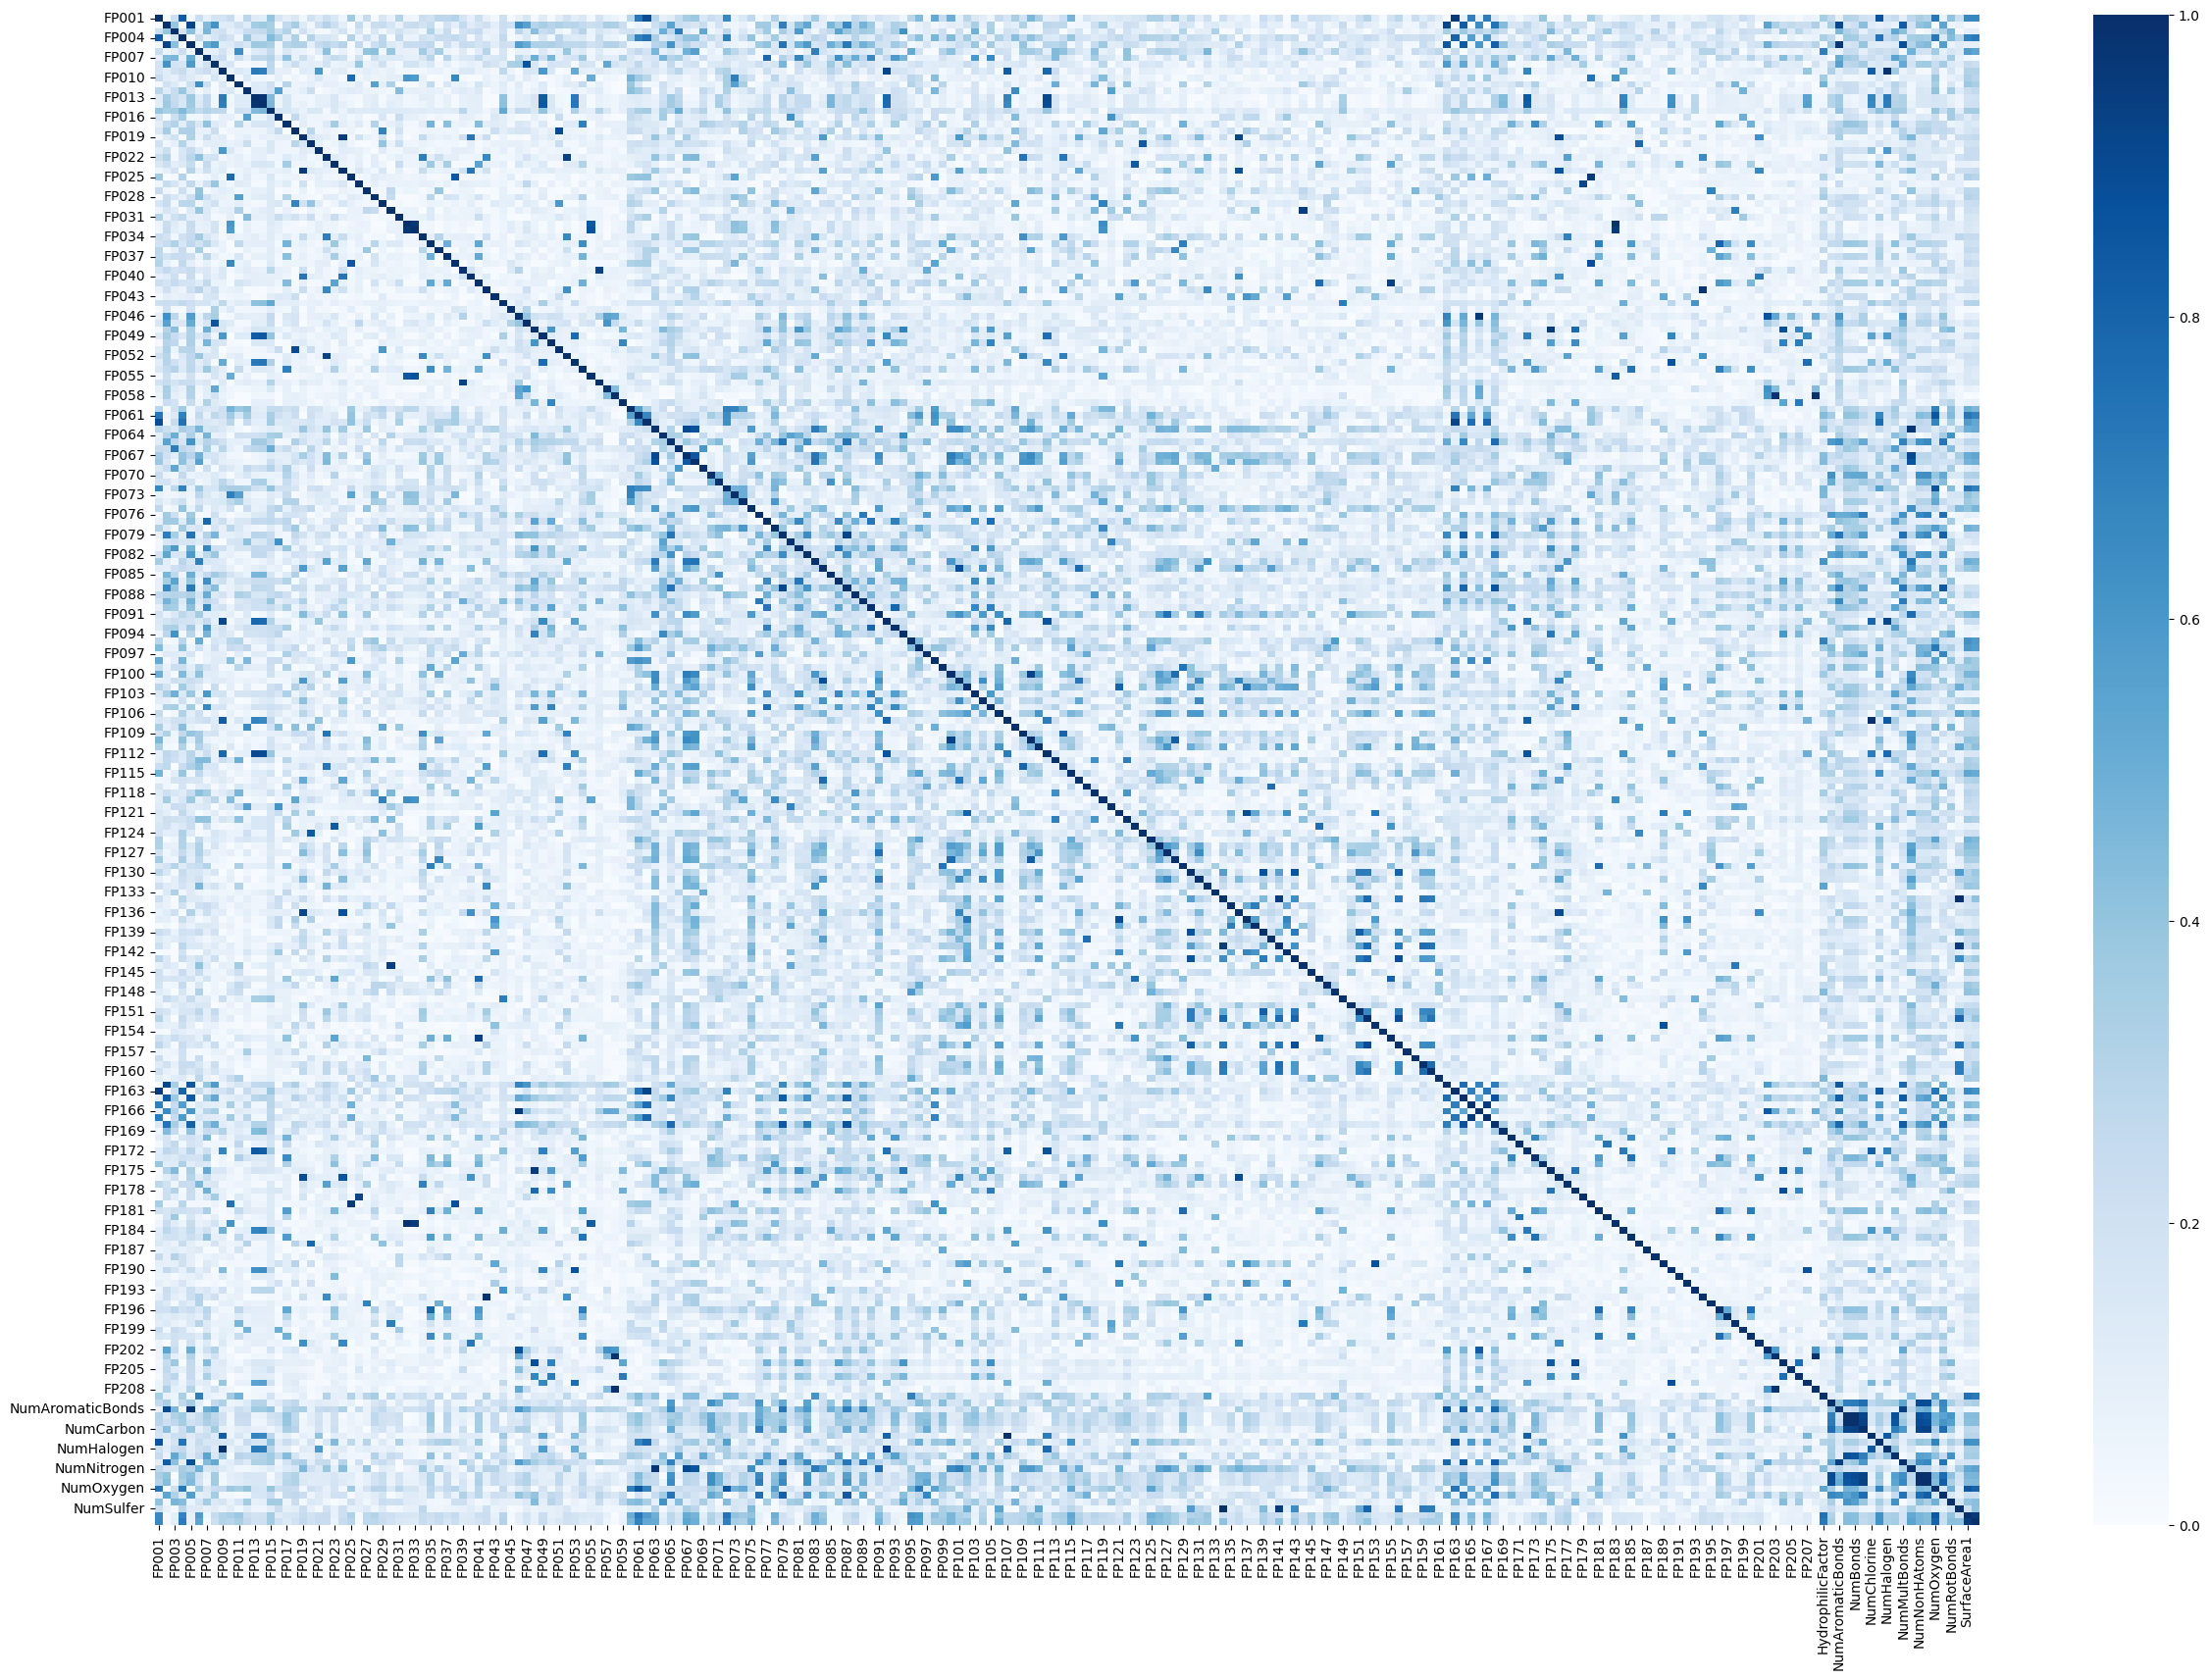

In [54]:
corr_matrix = X.corr()
abs_corr = np.abs(corr_matrix)

plt.figure(figsize=(30,20))
sns.heatmap(abs_corr, vmin=0, vmax=1, cmap="Blues") #check for high absolute value correlation
plt.show()

In [55]:
def remove_correlated_covariates(X, thresh):
    """
    Iteratively removes covariates with a higher correlation than the specified threshold.
    """
    abs_corr = np.abs(X.corr())
    np.fill_diagonal(abs_corr.values, 0) # we set the diagonal values to 0
    abs_corr = abs_corr.where(np.tril(np.ones(abs_corr.shape)).astype(bool)) # we just mask the upper triangular part of the matrix
    
    while (abs_corr>thresh).sum().sum()>0:
        variable1, variable2 = abs_corr.stack().idxmax() #extract variables with higher correlation

        # drop the variable that in average has higher correlation with the other variables
        if abs_corr.stack()[variable1].mean() > abs_corr.stack()[variable2].mean():
            #drop variable1
            X = X.drop(columns=[variable1])
        else:
            #drop variable2
            X = X.drop(columns=[variable2])

        # recalculate abs corr matrix
        abs_corr = np.abs(X.corr())
        np.fill_diagonal(abs_corr.values, 0) 
        abs_corr = abs_corr.where(np.tril(np.ones(abs_corr.shape)).astype(bool))
           
    return X

In [56]:
X_train_uncorrelated = remove_correlated_covariates(X_train, 0.8)
X_test_uncorrelated = X_test[X_train_uncorrelated.columns] #also use the same columns for the test sample

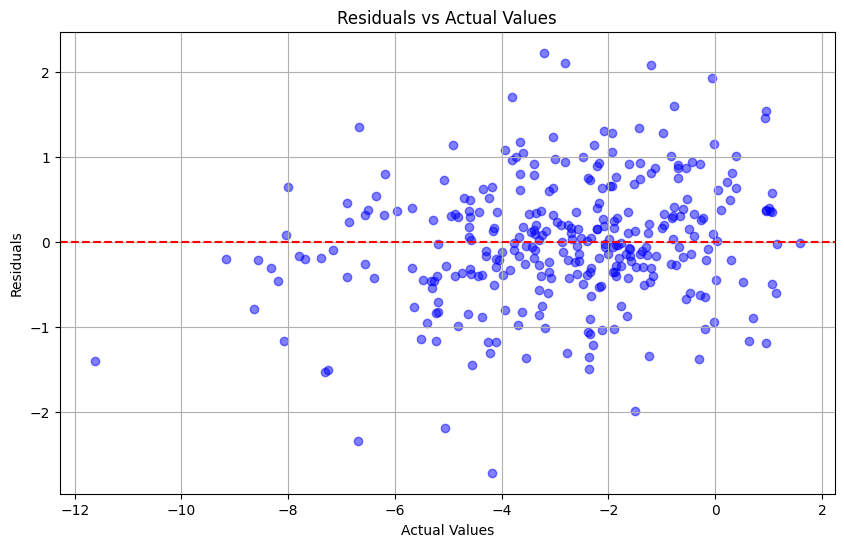

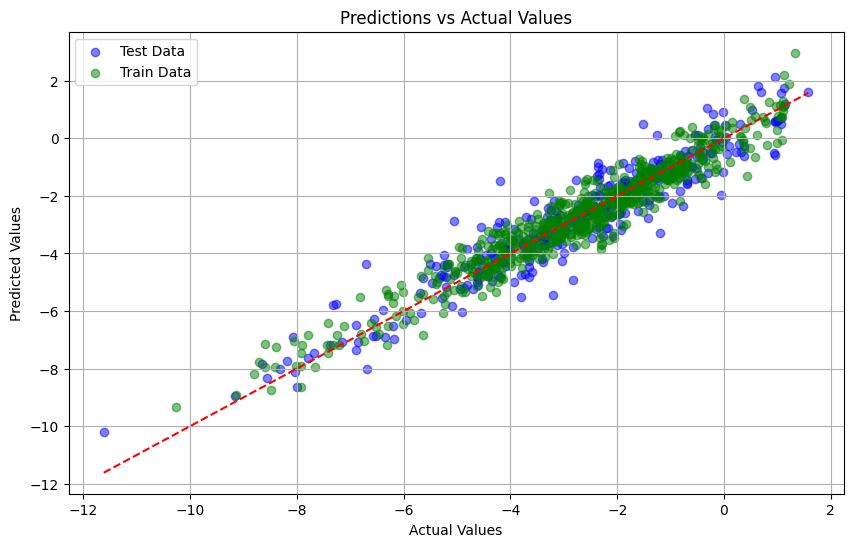

In [57]:
reg_uncorrelated = LinearRegression()
reg_uncorrelated.fit(X_train_uncorrelated, y_train)
y_pred = reg_uncorrelated.predict(X_test_uncorrelated)
y_fitted = reg_uncorrelated.predict(X_train_uncorrelated)

residuals=y_test-y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, color='blue', alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5, label='Test Data')
plt.scatter(y_train, y_fitted, color='green', alpha=0.5, label='Train Data')
plt.plot(np.linspace(min(y), max(y)), np.linspace(min(y), max(y)), color='red', linestyle='--')
plt.title('Predictions vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

### Cross-validation

In [58]:
X_uncorrelated = remove_correlated_covariates(X, 0.8)

reg_uncorrelated = LinearRegression()

cv = ShuffleSplit(n_splits=5, test_size=0.33, random_state=30)

scores = cross_val_score(reg_uncorrelated, X_uncorrelated, y, cv=cv, scoring="neg_root_mean_squared_error")

cv_rmse = np.mean(-1*scores)

print(f"Cross-validated RMSE: {cv_rmse}")

Cross-validated RMSE: 0.7572709754331772


**Cross validated RMSE becomes a bit smaller** with this heuristic approach. However, it did not help that much.

### Principal Component Regression (PCR) approach

While the previous heuristic approach addresses multicollinearity by removing highly correlated variables, it doesn't guarantee that (more generally) linear combinations of predictors are uncorrelated with each other. To address this issue, we turn to Principal Component Regression (PCR).

PCR basically consists of using Principal Component Analysis (PCA) to reduce the dimensionality of the dataset prior to conduct the regression on a subset of the resulting PCs, selected as those explaining a desired share of variance in the feature data. In any case, the drawback is that this method sacrifices interpretability as each Principal Component (PC) is a linear combination of the original predictors, in other words, a PC is not as directly interpretable as a original variable.

One final note is that PCR is unsupervised, meaning it doesn't consider the response variable (Y) when selecting PCs. This poses a risk: if the selected PCs don't explain the variability of Y, the model's predictive performance may be deteriorated.

In [59]:
from sklearn.decomposition import PCA

In [60]:
rmse_test = []
rmse_train = []

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

for i in range(2, 60):
    pipeline = make_pipeline(
        PCA(n_components=i),
        LinearRegression()
    )
    
    cv_scores = cross_val_score(pipeline, X, y, cv=cv, scoring="neg_root_mean_squared_error")

    pipeline.fit(X_train, y_train)
    
    # Evaluate on training set
    y_fitted = pipeline.predict(X_train)
    train_rmse = root_mean_squared_error(y_train, y_fitted)
    rmse_train.append(train_rmse)
    
    # Store cross validated test RMSE
    rmse_test.append(-1*np.mean(cv_scores))

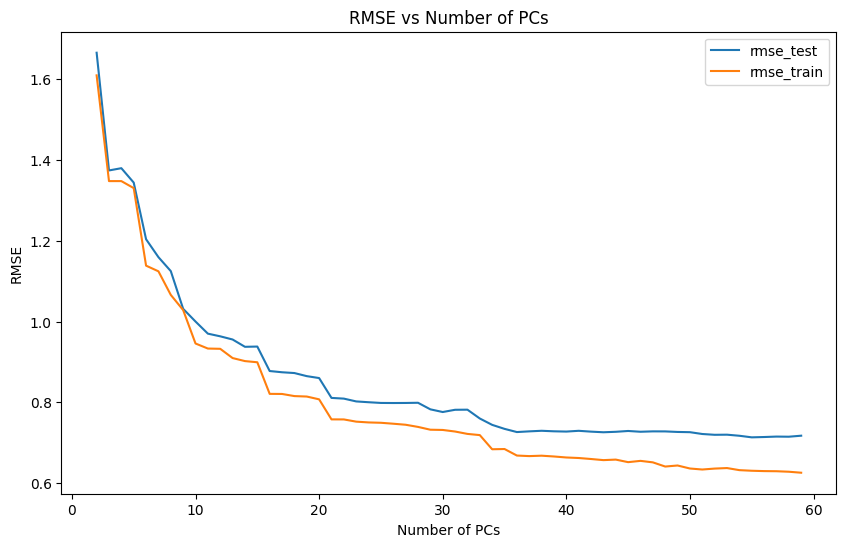

In [61]:
plt.figure(figsize=(10, 6))
plt.plot(range(2,60), rmse_test, label="rmse_test")
plt.plot(range(2,60), rmse_train, label="rmse_train")
plt.title('RMSE vs Number of PCs')
plt.xlabel('Number of PCs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

No significant performance improvement is observed beyond 35 PCs on the cross-validated RMSE. It seems that **choosing around 35 PCs is ideal**. 

This does not happen in this case, but it is important to keep in mind that even if the RMSE would become slightly smaller for a larger number of PCs, having more PCs adds complexity to the model. There should always be a qualitative trade-off to have in mind between the improvement in RMSE and the number of components.

In [62]:
rmse_test[33:37]

[0.73412238188132, 0.7262251652231139, 0.7279524983963529, 0.72937170045548]

**Cross validated RMSE also becomes a bit smaller** with respect to the previous approach.

#### Extra: Naively, how to know which column is more influential for each PC?

In [63]:
pca = PCA(n_components=35)
pca.fit(X)

# Get the loadings
loadings = pca.components_

In [64]:
loadings[0] # for the first principal component, these are the coefficients that multiply each original coluimn.

array([ 5.01709664e-02,  3.13110604e-03,  7.40357144e-03,  5.20310027e-02,
        7.88012590e-03,  4.13008327e-02,  2.44506603e-03,  1.77541959e-02,
       -2.05082873e-02,  1.77062036e-02,  2.19000564e-02,  1.40961698e-02,
       -1.01403985e-02, -1.07837720e-02,  1.84252320e-02,  9.05564740e-03,
        8.32384938e-03,  9.82928804e-03,  1.20800084e-02,  9.93289051e-03,
       -1.14474675e-02,  1.11906555e-02,  4.10332014e-03,  1.08619867e-02,
        1.46606123e-02, -3.80047390e-04,  1.26396447e-02,  1.36118667e-02,
        1.08312857e-02,  8.77758290e-03,  7.26105641e-03,  5.92627247e-03,
        5.34089977e-03,  1.01339949e-02,  8.44160848e-03,  1.00263584e-02,
        7.34791173e-03,  9.99156655e-03, -4.71828920e-03,  5.12826584e-03,
        7.64944921e-03,  7.76662436e-03,  3.92673345e-03, -1.02876948e-02,
        1.02858545e-03, -5.42736347e-03,  1.29656856e-02, -4.26235374e-03,
       -1.09657182e-02, -4.70162830e-03,  6.68240091e-03,  9.09569586e-03,
       -7.96002825e-03,  

In [65]:
idx = np.abs(loadings[0]).argmax() # the larger coefficient in absolute value corresponds to the variable contributing the most for the selected PC!

In [66]:
X.columns[idx] # for the 1st PC, this seems to be the most influential variable

'SurfaceArea2'

### Partial Least Squares (PLS) approach
While the previous PCR approach offers dimension reduction through PCA, it may not select PCs that explain the variability of the response variable. This limitation is overcome by Partial Least Squares (PLS).

PCR selects linear combinations of covariates to maximize variance in the feature space. Contrarily, PLS also chooses linear combinations that maximize covariance with the response variable. This means that PLS components not only summarize covariate variability but also exhibit maximum correlation with the response. Basically, PLS serves as a compromise between dimension reduction in the feature space and establishing a predictive relationship with the response. This makes that PLS can be viewed as a supervised dimension reduction procedure, whereas PCR remains unsupervised.

In general, PLS needs fewer components compared to PCR to achieve similar results, which is also good because it makes the interpretability of the model less complicated.

**Note**: Even with the constraint of correlation with the response variable, PLS tends to favor predictors with greater variability. That's why before conducting PLS it's essential to center and scale the predictors. Otherwise, the variables who have the largest variances will dominate the results of PLS.

In [67]:
from sklearn.cross_decomposition import PLSRegression

rmse_test = []
rmse_train = []

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

for i in range(1, 50):  
    pipeline = make_pipeline(
        PLSRegression(n_components=i), #scale is set to True by default
    )
    
    cv_scores = cross_val_score(pipeline, X, y, cv=cv, scoring="neg_root_mean_squared_error")
    
    pipeline.fit(X_train, y_train)
    
    # Evaluate on training set
    y_fitted = pipeline.predict(X_train)
    y_pred = pipeline.predict(X_test)
    train_rmse = root_mean_squared_error(y_train, y_fitted)
    rmse_train.append(train_rmse)
    
    # Store cross validated test RMSE
    rmse_test.append(-1 * np.mean(cv_scores))


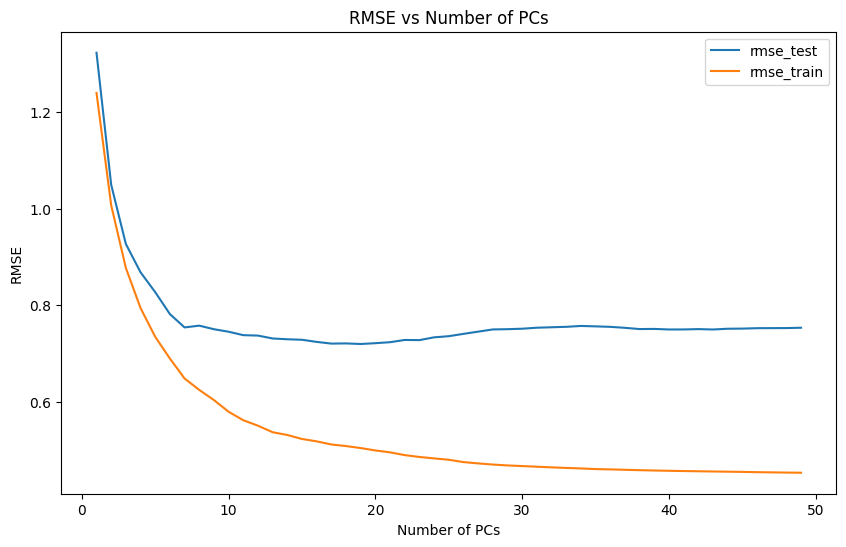

In [68]:
plt.figure(figsize=(10, 6))
plt.plot(range(1,50), rmse_test, label="rmse_test")
plt.plot(range(1,50), rmse_train, label="rmse_train")
plt.title('RMSE vs Number of PCs')
plt.xlabel('Number of PCs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [69]:
rmse_test[10:15]

[0.7381352152289425,
 0.7372500622532747,
 0.7312460699363841,
 0.7296468107131011,
 0.7285838055290776]

We notice similar performance on the validation data for both PCR and PLS models. However, **PLS achieves similar RMSE with notably fewer components**. The benefit lies in the increased interpretability of the model due to this reduction in components. Ultimately, PLS discovers a simpler model.

### Penalized regression models: Lasso and Ridge regression

In **Ordinary Least Squares (OLS)**, we minimize the objective function, which is the sum of the squared residuals:

$$SSE=\sum_{i=1}^{n}(y_i-\hat{y}_i)^2 $$

In **Lasso regression**, we maintain the same objective function but introduce a penalty term, which is the sum of the absolute values of the estimated coefficients:
 $$\lambda\sum\hat{\beta_j}$$

Increasing lambda results in:
- The higher the lambda, the more the parameters are shrunken towards zero.
- It has the variable selection property, meaning some parameters may be set to exactly zero.




In **Ridge regression**, the concept is similar, but larger parameters are penalized more due to the introduction of a second-order penalty:
$$\lambda\sum\hat{\beta_j^2}$$


So,
- Lasso executes a variable selection property, implying that some parameters will be set to exactly zero.
- Ridge has a regularizing effect, shrinking parameters close to zero.

Mean Squared Error (MSE) comprises both variance and bias. Higher variance leads to lower bias, and vice versa. When collinearity exists, variance tends to be high, often resulting in overfitting scenarios.

**Penalized models can intentionally increase bias within the model to significantly decrease model variance. This approach serves to mitigate collinearity-related issues.**

**Elastic net** models generalize the concepts of ridge and lasso regularization by combining both penalties with two distinct lambdas. This approach combines the regularization aspects of ridge regression with the feature selection capabilities of lasso.

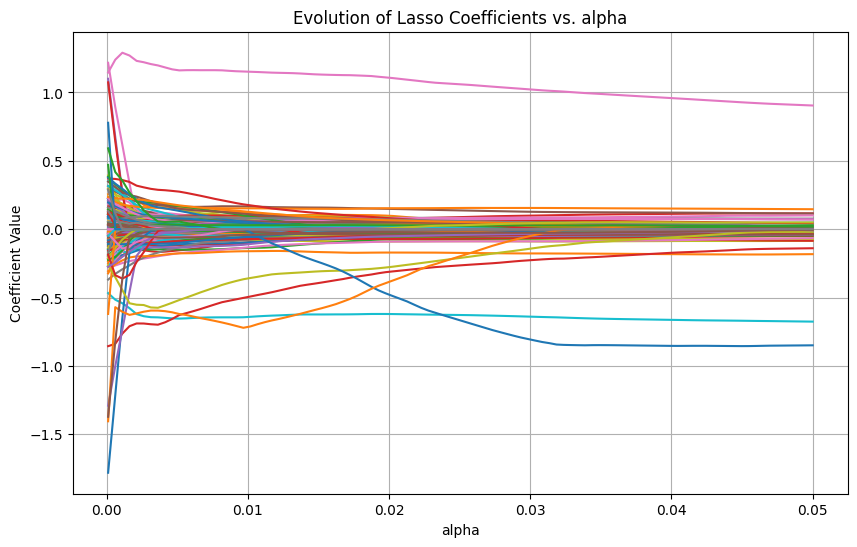

In [70]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)


rmse_test = []
rmse_train = []

coefficients = []

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

alphas = np.linspace(0.0001, 0.05, 100)

for alpha in alphas: 
    pipeline = make_pipeline(
        StandardScaler(),
        Lasso(alpha=alpha, random_state=30)
    )
    #https://stats.stackexchange.com/questions/86434/is-standardisation-before-lasso-really-necessary
    #https://stats.stackexchange.com/questions/19523/need-for-centering-and-standardizing-data-in-regression
    
    cv_scores = cross_val_score(pipeline, X, y, cv=cv, scoring="neg_root_mean_squared_error")
    
    pipeline.fit(X_train, y_train)

    coefficients.append(pipeline.named_steps["lasso"].coef_) # store covariate coefficients at each correspondign alpha value
    
    # Evaluate on training set
    y_fitted = pipeline.predict(X_train)
    train_rmse = root_mean_squared_error(y_train, y_fitted)
    rmse_train.append(train_rmse)
    
    # Store cross validated test RMSE
    rmse_test.append(-1 * np.mean(cv_scores))

coefficients = np.array(coefficients)

plt.figure(figsize=(10, 6))
for i in range(coefficients.shape[1]):
    plt.plot(alphas, coefficients[:, i])

plt.title('Evolution of Lasso Coefficients vs. alpha')
plt.xlabel('alpha')
plt.ylabel('Coefficient Value')
plt.grid(True)
plt.show()

The plot above shows the evolution of the coefficients as alpha increases. The higher the penalization induced by alpha, the more coefficients are shrunken to zero. This plot exhibits the feature selection property of Lasso.

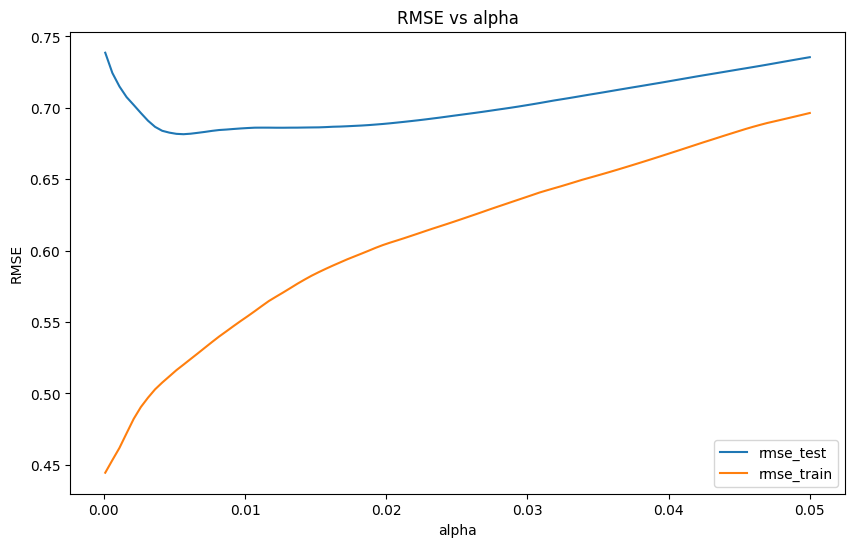

In [71]:
plt.figure(figsize=(10, 6))
plt.plot(alphas, rmse_test, label="rmse_test")
plt.plot(alphas, rmse_train, label="rmse_train")
plt.title('RMSE vs alpha')
plt.xlabel('alpha')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [72]:
alpha_idx = np.array(rmse_test).argmin() 

In [73]:
alphas[alpha_idx] # alpha that minimizes the RMSE

0.005644444444444445

In [74]:
rmse_test[alpha_idx] # min RMSE that can be achieved

0.6815294656354134

In [75]:
sum(coefficients[alpha_idx]==0) # no. coefficients that were shrunken to 0

92

**Lasso already offers a significant improvement in RMSE over our previous results**. Close to 100 variables were shrunk to 0 for the best lambda value.

### Ridge

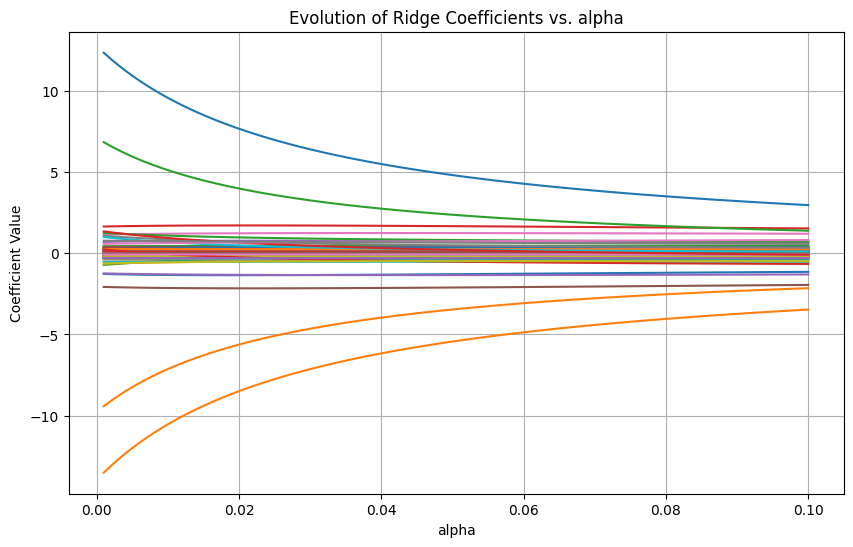

In [76]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

rmse_test = []
rmse_train = []

coefficients = []

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=30)

alphas = np.linspace(0.001, 0.10, 100)

for alpha in alphas:  
    pipeline = make_pipeline(
        StandardScaler(),
        Ridge(alpha=alpha, random_state=42)
    )
    #https://stats.stackexchange.com/questions/86434/is-standardisation-before-lasso-really-necessary
    #https://stats.stackexchange.com/questions/19523/need-for-centering-and-standardizing-data-in-regression
    
    
    cv_scores = cross_val_score(pipeline, X, y, cv=cv, scoring="neg_root_mean_squared_error")

    pipeline.fit(X_train, y_train)

    coefficients.append(pipeline.named_steps["ridge"].coef_)
    
    # Evaluate on training set
    y_fitted = pipeline.predict(X_train)
    train_rmse = root_mean_squared_error(y_train, y_fitted)
    rmse_train.append(train_rmse)
    
    # Store cross validated test RMSE
    rmse_test.append(-1 * np.mean(cv_scores))

coefficients = np.array(coefficients)

plt.figure(figsize=(10, 6))
for i in range(coefficients.shape[1]):
    plt.plot(alphas, coefficients[:, i])

plt.title('Evolution of Ridge Coefficients vs. alpha')
plt.xlabel('alpha')
plt.ylabel('Coefficient Value')
plt.grid(True)
plt.show()

In the plot above, Ridge's regularizing effect is clearly exhibited. Dominant coefficients decrease as alpha increases. However, no coefficients are shrunken to zero.

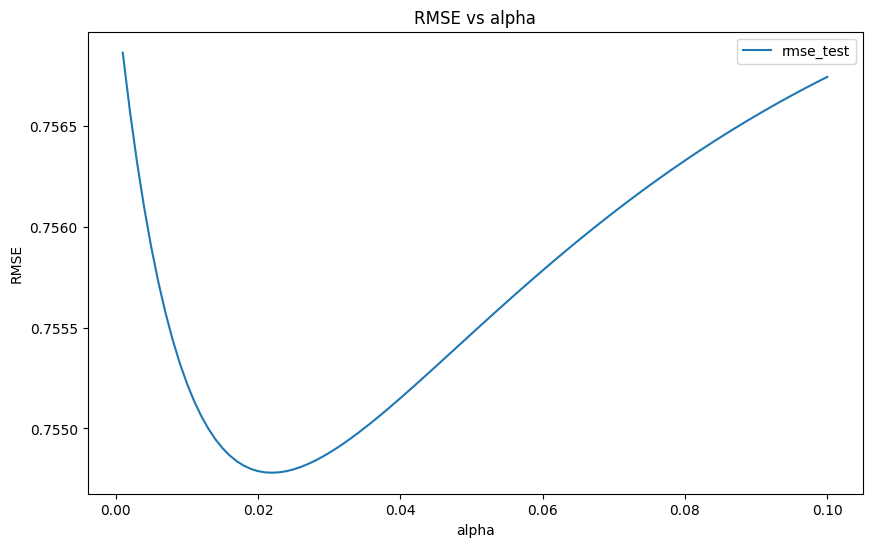

In [77]:
plt.figure(figsize=(10, 6))
plt.plot(alphas, rmse_test, label="rmse_test")
#plt.plot(alphas, rmse_train, label="rmse_train")
plt.title('RMSE vs alpha')
plt.xlabel('alpha')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [78]:
alpha_idx = np.array(rmse_test).argmin() 

In [79]:
alphas[alpha_idx] # alpha that minimizes the RMSE

0.022000000000000002

In [80]:
rmse_test[alpha_idx] # min RMSE that can be achieved

0.7547808887996195

In [81]:
sum(coefficients[alpha_idx]==0) # no. coefficients that were shrunken to 0

0

# Conclusion

When faced with high-dimensional data, it is important to reduce the number of variables variables. This makes the models less prone to overfitting and easier to understand. We used different techniques to reduce the number of variables in the solubility dataset, including heuristic reduction, Principal Component Regression (PCR), Partial Least Squares (PLS), and Penalized Regression methods such as Lasso and Ridge regression.

Lasso regression was the most effective approach, reducing the RMSE and removing redundant predictors. Lasso made the model simpler and more interpretable without losing its ability to predict or having to recombine the covariates into principal components.